# Control PID

***Linealizar ecuaciones diferenciales no lineales para diseñar controles PID***

In [1]:
# Importamos librerias que utilizaremos en el notebook

%matplotlib inline

import sympy
import control
import matplotlib.pyplot as plt
import numpy
import ipywidgets as widgets

<table>
    <tr>
        <td><img src="http://cpm.davinsony.com/clases/svg/python.svg" width="100px"></td>
        <td><img src="http://cpm.davinsony.com/clases/svg/sympy.svg" width="130px"></td>
        <td><img src="http://cpm.davinsony.com/clases/svg/matplotlib.svg" width="300px"></td>
        <td><img src="http://cpm.davinsony.com/clases/svg/numpy.svg" width="200px"></td>
        <td><img src="http://cpm.davinsony.com/clases/svg/ipywidgets.svg" width="200px"></td>
    </tr>
</table>

## Linealización en control 

El diseño de controladores se facilita cuando tenemos sistemas que son lineales. En el proceso de diseño de controladores. Se siguen la siguientes etapas.

1. Se obtiene un **modelo no lineal**.
2. Se obtiene un **modelo lineal** a través de linealización. 
3. Se **propone un controlador** para el modelo lineal.
4. Se **prueba el controlador** en el sistema real. 

La linealización se hace para las ecuaciones diferenciales no lineales del sistema. 

### Funciones no lineales

Antes de linealizar ecuaciones diferenciales, empecemos analizando funciones no lineales. 

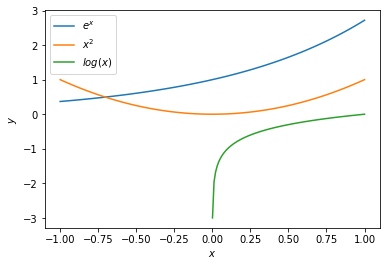

In [2]:
x = numpy.linspace(-1, 1, 100)
xpos = numpy.linspace(0.001, 1, 100)

plt.figure()
ax = plt.subplot(111)
ax.plot(x, numpy.exp(x), label="$e^x$");           # Función exponencial
ax.plot(x,x*x, label="$x^2$");                     # Función cuadratica
ax.plot(xpos, numpy.log10(xpos), label="$log(x)$") # Función logaritmica
ax.legend()
plt.xlabel('$x$')
plt.ylabel('$y$');

### Linealización de funciones

Para linealizar funciones utilizamos la serie de _Taylor_. La cual se define como:

$$f(x) = \sum_{n=o}^\infty \, \frac{f^{(n)}(a)}{n!}(x-a)^n$$

escrita de otra forma:

$$f(x) \approx f(a) + \frac{f'(a)}{1!}(x-a) + \frac{f''(a)}{2!}(x-a)^2 + \frac{f^{(3)}(a)}{3!}(x-a)^3 + \cdots$$

se toma únicamente el termino lineal.

$$f(x) \approx f(a) + \frac{f'(a)}{1!}(x-a) $$

In [2]:
## Parametros del modelo

a = widgets.FloatSlider(value=1,min=-2,max=2,step=0.1,description='a')

## Definicion de la simulacion

def exponencial(a):
    x = numpy.linspace(-2,2,100)
    y = numpy.exp(x)
    yl = numpy.exp(a) + numpy.exp(a)*(x-a)
    plt.plot(x,y)
    plt.plot(x,yl)
    plt.scatter(a,numpy.exp(a),c='k')
    plt.title('Linealización de la función exponencial')
    plt.xlabel('x')
    plt.ylabel('y')

## Presentación de los resultados    
    
plot_exponencial = widgets.interactive_output(exponencial,{'a':a})      
widgets.HBox([a,plot_exponencial])

### Ejemplo Tanque

La ecuación del tanque es la siguiente, donde $A$ es el area del tanque, $a$ es el area del orificio del tanque, $Q(t)$ es el caudal de entrada:

$$A\,\frac{d\,h(t)}{dt}+a\sqrt{2g\,h(t)}=Q(t)$$

### Pasos para la linealización

Los pasos para la linealización de ecuaciones diferenciales son los siguientes: 
    
- Partimos de la ecuación diferencial.

In [4]:
A,a,g,t,h,Q = sympy.symbols('A a g t h Q')
hs = sympy.Function('h')(t)
qs = sympy.Function('Q')(t)

Eq_tanque = sympy.Eq(A*sympy.diff(hs,t)+a*sympy.sqrt(2*g*hs),qs); display(Eq_tanque)

Eq(A*Derivative(h(t), t) + sqrt(2)*a*sqrt(g*h(t)), Q(t))

- Despejamos la derivada de mayor orden y definimos esta ecuación como una función.

In [5]:
F = sympy.Function('F')(h,Q)
Fhq = sympy.solve(Eq_tanque,sympy.diff(hs,t))[0]
Eq_tanque2 = sympy.Eq(F,Fhq); display(Eq_tanque2)

Eq(F(h, Q), (-sqrt(2)*a*sqrt(g*h(t)) + Q(t))/A)

- Buscamos o imponemos el punto de linealización, normalmente se escoje el estado estacionario como punto de linealización. 

In [6]:
hss, qss = sympy.symbols('h_{ss} Q_{ss}')
Eq_estacionario = sympy.Eq(hss,sympy.solve(Eq_tanque2.subs(F,0),hs)[0].subs(qs,qss)); display(Eq_estacionario)
Eq_estacionario2 = sympy.Eq(qss,sympy.solve(Eq_tanque2.subs(F,0),qs)[0].subs(hs,hss)); display(Eq_estacionario2)

Eq(h_{ss}, Q_{ss}**2/(2*a**2*g))

Eq(Q_{ss}, sqrt(2)*a*sqrt(g*h_{ss}))

Este es entonces el punto de linealización $(h_{ss},Q_{ss})$

- Aplicamos serie de _Taylor_ a la función $F$

In [7]:
taylor = sympy.Eq(F,F.subs(h,hss).subs(Q,qss)+sympy.diff(F,h).subs(h,hss).subs(Q,qss)*(hs-hss)+sympy.diff(F,Q).subs(h,hss).subs(Q,qss)*(qs-qss))
display(taylor)

Eq(F(h, Q), (-Q_{ss} + Q(t))*Derivative(F(h_{ss}, Q_{ss}), Q_{ss}) + (-h_{ss} + h(t))*Derivative(F(h_{ss}, Q_{ss}), h_{ss}) + F(h_{ss}, Q_{ss}))

para el tanque tenemos

In [8]:
lineal = sympy.Eq(F,Fhq.subs(hs,hss).subs(qs,qss)+sympy.diff(Fhq,hs).subs(hs,hss).subs(qs,qss)*(hs-hss)+sympy.diff(Fhq,qs).subs(hs,hss).subs(qs,qss)*(qs-qss))
display(lineal)

Eq(F(h, Q), -sqrt(2)*a*sqrt(g*h_{ss})*(-h_{ss} + h(t))/(2*A*h_{ss}) + (-Q_{ss} + Q(t))/A + (Q_{ss} - sqrt(2)*a*sqrt(g*h_{ss}))/A)

- La ecuación linearizada del tanque quedaría : 

In [9]:
lineal2 = sympy.Eq(sympy.diff(hs,t),lineal.rhs)
display(lineal2)

Eq(Derivative(h(t), t), -sqrt(2)*a*sqrt(g*h_{ss})*(-h_{ss} + h(t))/(2*A*h_{ss}) + (-Q_{ss} + Q(t))/A + (Q_{ss} - sqrt(2)*a*sqrt(g*h_{ss}))/A)

- En la ecuación anterior vamos a remplazar las variable $h$ y $Q$ por las variables desviadas $h'$ y $Q'$.

$$h' = h - h_{ss} \qquad Q' = Q - Q_{ss}$$

- Remplazando tenemos:

In [10]:
hp = sympy.Function("h'")(t)
qp = sympy.Function("Q'")(t)
Eq_diff = lineal2.subs(hs,hp+hss).subs(qs,qp+qss).subs(qss,Eq_estacionario2.rhs)
Eq_diff2 = sympy.Eq(sympy.simplify(Eq_diff.lhs),Eq_diff.rhs);
display(Eq_diff2)

Eq(Derivative(h'(t), t), -sqrt(2)*a*sqrt(g*h_{ss})*h'(t)/(2*A*h_{ss}) + Q'(t)/A)

### Ejercicios de Linealización

Linealizar las siguientes funciones:

$$m\frac{d^2y(t)}{dt^2}+b\frac{dy(t)}{dt}+k\,y(t)^3 = - F(t)$$

$$\frac{d^2y(t)}{dt^2} + \sin(\omega t)\frac{dy(t)}{dt} + e^{t/\tau}y(t) = 0$$

$$t\frac{d^2y(t)}{dt^2}+\sin(\omega t)\frac{dy(t)}{dt} = 0$$

## Root Locus

El _root locus_ presenta los caminos de los polos en el plano complejo para un sistema en lazo cerrado en donde la ganancia del controlador $K$ varia de $0$ hasta $\infty$.

- **root**: o raíz, se refiere a la solución de la ecuación carácteristica de la funcion de transferencia. 
- **locus**: simplemente significa camino, posición o ubicación. 

Veremos como construir los caminos del _root locus_ a partir de la información de los polos en lazo abierto de un sistema. 

### Ejemplo 1

Consideremos un sistema de primer orden con una constante de tiempo $\tau=2\text{ seg}$:

In [11]:
ss = sympy.Symbol('s'); G1A = 1/(1+2*ss); display(G1A)

1/(2*s + 1)

Este sistema tiene un polo que es $s=-0.5$. Si le agregamos al sistema un controlador con ganancia $K$ en lazo abierto. 

In [12]:
sK = sympy.Symbol('K'); G1B = G1A*sK; display(G1B)

K/(2*s + 1)

La posición de polo no cambia, el polo sigue siendo $s=-0.5$, ¿qué pasa en lazo cerrado?

En lazo cerrado, tendremos la siguiente función de transferencia. 

In [13]:
G1C = sympy.simplify(G1B/(1+G1B)); display(G1C)

K/(K + 2*s + 1)

Aquí vemos, que la posición del polo depende del valor que tome $K$. 

In [14]:
G1Cpole = sympy.Eq(ss,sympy.solve(sympy.denom(G1C),ss)[0]); display(G1Cpole)

Eq(s, -K/2 - 1/2)

Comienza en $s=-0.5$ cuando $K=0$, y este polo se vuelve más negativo cuando $K$ se incrementa. 

En la siguiente figura interactiva se puede ver el comportamiento del polo:

In [15]:
## Parametros del modelo

param_K = widgets.FloatSlider(value=1,min=0,max=20,step=0.1,description='Ganacia $K$', orientation="vertical")

## Definicion de la simulacion

def root_locus_ejemplo_1(K):
    kvals = numpy.linspace(0,20,100)
    real  = -(kvals+1)/2
    imag  = kvals*0
    plt.plot(real,imag,c='k')
    plt.scatter(-(K+1)/2,0,marker="x")
    plt.title('Root locus para el ejemplo 1 con función de transferencia $1/(2\,s+1)$')
    plt.xlabel('Real')
    plt.ylabel('Imaginario')

## Presentación de los resultados    
    
plot_root_locus_ejemplo_1 = widgets.interactive_output(root_locus_ejemplo_1,{'K':param_K})      
widgets.HBox([param_K,plot_root_locus_ejemplo_1])

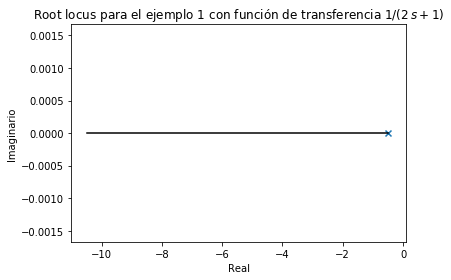

In [16]:
root_locus_ejemplo_1(0)

Del mismo modo se puede usar la funcion *root_locus* de la libreria **control**, para obtener la gráfica. La función toma como entrada la funcion de transferencia en lazo abierto sin controlador.

$$\frac{1}{2\,s+1}$$

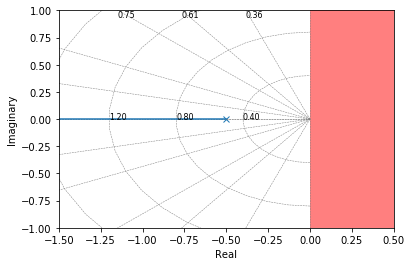

In [17]:
G1D = control.tf(1,[2,1]);
control.root_locus(G1D);
plt.axvspan(0, 0.5, facecolor='r', alpha=0.5)
plt.xlim(-1.5,0.5);

La zona en rojo corresponde a los valores reales positivos, esta zona se conoce como lo región inestrable, si hay al menos un polo del sistema en esta zona el sistema será inestable. 

## Grafica del root locus manual 

1. El número de _locis_ (caminos) es igual al orden de la ecuación característica.
2. Cada _locis_ empieza en un polo del lazo abierto ($K=0$) y termina en un cero del lazo abierto o en infinito ($K=\infty$).
3. Los _locis_ recorren el eje real, o recorren caminos simétricos con respecto al eje real cuando empiezan en polos conjugados. 
4. Un punto en el eje real es parte de un _locis_ si el número de polos y ceros a la derecha de ese punto es impar. 
5. Lejos de los polos y ceros del lazo abierto, los _locis_ se vuelven asimptoticos a una lineas que tienen angulos $\alpha_n$ con respecto al eje real.

    $$\alpha_n=\pm \frac{n\pi}{P-Z} \qquad\text{donde,}\quad n=1,3,5,..., P-Z$$

6. Las asimptotas intersectan al eje real en un punto $S$, conocido como centroide del mapa de polos y ceros, dado por:

    $$S=\frac{\Sigma \text{polos} - \Sigma \text{ceros}}{P-Z}$$

### Ejemplo 2

Analicemos la siguiente función de transferencia. 

In [18]:
s   = control.tf([1,0],1)
G2s = (1+0.5*ss)/(ss*(1+0.3*ss)*(1+0.6*ss+0.4*ss**2)); display(G2s)
G2  = (1+0.5*s )/(s *(1+0.3*s )*(1+0.6*s +0.4*s **2)); 

(0.5*s + 1)/(s*(0.3*s + 1)*(0.4*s**2 + 0.6*s + 1))

- ¿Cuántos polos tiene, y cuánto valen?

In [19]:
polos_G2 = control.pole(G2)
print("Tiene P = %d polos y valen: \n\n%s" % (len(polos_G2),'\n'.join(map(str, polos_G2))))

Tiene P = 4 polos y valen: 

(-3.3333333333333357+0j)
(-0.7499999999999991+1.3919410907075038j)
(-0.7499999999999991-1.3919410907075038j)
0j


- ¿Cuántos ceros tiene, y cuánto valen?

In [20]:
ceros_G2 = control.zero(G2)
print("Tiene Z = %d ceros y vale: \n\n%s" % (len(ceros_G2),'\n'.join(map(str, ceros_G2))))

Tiene Z = 1 ceros y vale: 

-2.0


- ¿Cuál es la ecuación característica? 

In [21]:
Eq_caracteristica = sympy.Eq(sympy.denom(G2s),0); display(Eq_caracteristica)

Eq(s*(0.3*s + 1)*(0.4*s**2 + 0.6*s + 1), 0)

- ¿Cómo graficamos el _root locus_ de esta función de transferencia? 

Se puede partir del mapa de polos y ceros y de la reglas para graficarlo manualmente. 

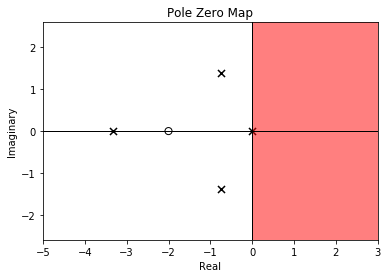

In [22]:
control.pzmap(G2);
plt.axvspan(0, 4, facecolor='r', alpha=0.5)
plt.xlim(-5,3);

O directamente con la función *root_locus*

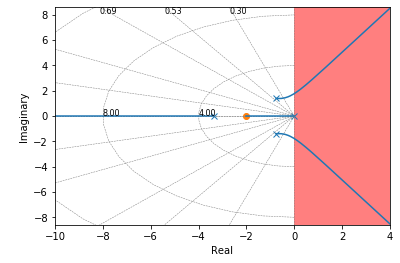

In [23]:
control.root_locus(G2);
plt.axvspan(0, 4, facecolor='r', alpha=0.5)
plt.xlim(-10,4);

**Existe un valor limite para $K$ el cual hace que los caminos pasen de la zona real negativa a la zona real positiva.** Este valor se conoce como $K_u$ la ganacia última del sistema. Para encontrarlo se puede usar criterio de _Routh_ o usando la función _margin_.

### Calculo manual de la matriz de *Routh*

Para la matriz de *Routh* debemos empezar por encontra la ecuación característica del sistema en lazo cerrado.

In [53]:
carac2 = sympy.expand(sympy.denom(sympy.simplify(G2s*sK/(1+G2s*sK)))); display(carac2)

0.5*K*s + K + 0.12*s**4 + 0.58*s**3 + 0.9*s**2 + s

Buscamos los coeficientes:

In [61]:
coeff2 = [];
for i in range(5):
    coeff2.append(carac2.coeff(ss,i)); print("El valor que acompaña a s^%d es %s" % (i,coeff2[i]))

El valor que acompaña a s^0 es K
El valor que acompaña a s^1 es 0.5*K + 1
El valor que acompaña a s^2 es 0.900000000000000
El valor que acompaña a s^3 es 0.580000000000000
El valor que acompaña a s^4 es 0.120000000000000


Completamos la matriz de *Routh*

In [81]:
print("s⁴ \t %3.2f \t\t\t\t\t\t %3.2f \t\t %s" %(coeff2[4],coeff2[2],coeff2[0]))
print("s³ \t %3.2f \t\t\t\t\t\t %s \t %s"      %(coeff2[3],coeff2[1],0))

s21 = sympy.simplify((coeff2[3]*coeff2[2]-coeff2[4]*coeff2[1])/coeff2[3])

print("s² \t %s \t %s"      %(s21,coeff2[0]))

s11 = sympy.simplify((s21*coeff2[1]-coeff2[3]*sK)/s21)

print("s¹ \t X")
print("s⁰ \t K")

print("\n donde X = %s"%(s11))

s⁴ 	 0.12 						 0.90 		 K
s³ 	 0.58 						 0.5*K + 1 	 0
s² 	 0.693103448275862 - 0.103448275862069*K 	 K
s¹ 	 X
s⁰ 	 K

 donde X = 1.0*(0.0517241379310345*K**2 + 0.336896551724138*K - 0.693103448275862)/(0.103448275862069*K - 0.693103448275862)


La primer columna de la matriz debe toda tener el mismo signo. Ya que los dos primeros elementos son positivos el resto también. 

In [89]:
display(sympy.solve(s11,sK))

s11.subs(sK,1.6); # Verificamos la desigualdad. 

[-8.15624601369002, 1.64291268035669]

De aqui tenemos que... $K_u= 1.643$

Usando la función _margin_ tenemos:

In [24]:
margin_G2,_,_,_ = control.margin(G2)
display(margin_G2)

1.6429126803566858

El primer valor reportado es la ganacia última $K_u \approx 1.643$

Podemos verificar que pasa al sistema en lazo cerrado con valores de $K$ alrededor de $K_u$

In [25]:
## Parametros del modelo

param_K = widgets.FloatSlider(value=1.6,min=1,max=2,step=0.01,description='Ganacia $K$')

## Definicion de la simulacion

def respuesta_ejemplo_2(K):
    G2_close_loop = control.feedback(G2*K,1)
    t, y = control.step_response(G2_close_loop)
    plt.plot(t,y)
    plt.title('Respuesta temporal para el sistema \n%s' % (G2_close_loop))
    plt.xlabel('tiempo')
    plt.ylabel('amplitud')

## Presentación de los resultados    
    
plot_respuesta_ejemplo_2 = widgets.interactive_output(respuesta_ejemplo_2,{'K':param_K})      
widgets.VBox([plot_respuesta_ejemplo_2,param_K])

Para $K=1.5$

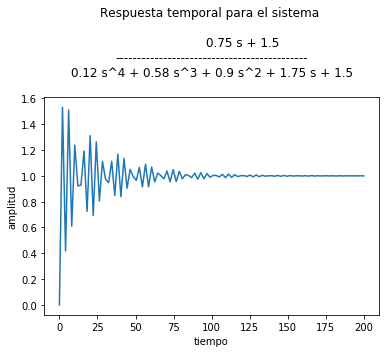

In [26]:
respuesta_ejemplo_2(1.5)

Para $K=1.65$

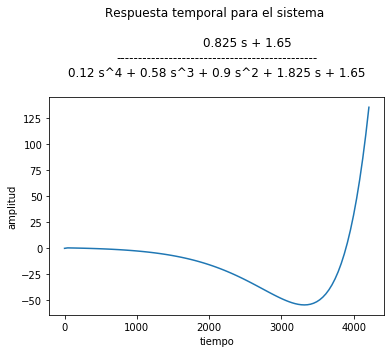

In [27]:
respuesta_ejemplo_2(1.65)

### Ejercicio

Para la siguiente función: 

In [28]:
G3 = 1/(ss*(ss+1)*(ss+8)); display(G3)

1/(s*(s + 1)*(s + 8))

Realizar:

- Encontrar el *root locus*
- Identificar la ganancia última
- Estudiar la respuesta temporal

### Aproximación del retardo

Para considerar el retardo en los sistemas y diseñar el controlador PID, debemos aproximar el retardo:
    
- Por serie de _Taylor_

$$f(x) = \sum_{n=0}^{\infty}\frac{f^{(n)}(a)}{n!}(x-a)^n \qquad\text{de ahí,}\quad e^{-\theta s}\approx (1-\theta s) $$

- Por aproximación de _Padé_. Para el retardo tenemos

$$e^{-\theta s}\approx \frac{1+\frac{\theta s}{2}}{1-\frac{\theta s}{2}}$$

![USS New Mexico (BB-40) in 1921](https://cap.davinsony.com/media/slide/img/slide-561.png)

## Control PID

**¿Qué es PID?**

PID es un control **p**roporcional **i**ntegral **d**erivativo. Se representa por la siguiente ecuación: 

$$u(t) = K_p\,e(t) + K_i \int_0^t e(\tau)d\tau + Kd_\, \frac{e(t)}{dt}$$

Los coefficientes $K_p$, $K_i$ y $K_d$ se definen positivos. La anterior expresión puede ser escrita en el dominio de _Laplace_ de la siguiente forma: 

$$K(s)= K_p + \frac{K_i}{s}+K_d\,s$$

### PID en las peliculas

Intensamente (*inside-out*)

<table>
    <tbody>
        <tr>
            <td style="vertical-align:top">
                <img src="http://cpm.davinsony.com/clases/png/movie_inside_out_logo.png" width="110px"/>
            </td>
            <td style="vertical-align:bottom">
                <img src="http://cpm.davinsony.com/clases/png/movie_inside_out_anger.png" width="150px"/>
            </td>
            <td style="vertical-align:bottom">
                <img src="http://cpm.davinsony.com/clases/png/movie_inside_out_disgust.png" width="120px"/>
            </td>
            <td style="vertical-align:bottom">
                <img src="http://cpm.davinsony.com/clases/png/movie_inside_out_fear.png" width="110px"/>
            </td>
        </tr>
        <tr>
            <td></td>
            <td style="text-align:center; color:#ae2d26; font-size:2em">Proporcional</td>
            <td style="text-align:center; color:#1b3f23; font-size:2em">Integral</td>
            <td style="text-align:center; color:#6e5993; font-size:2em">Derivativo</td>
        </tr>
         <tr>
             <td></td>
            <td style="text-align:center; color:#ae2d26; font-size:1.3em">reactivo</td>
            <td style="text-align:center; color:#1b3f23; font-size:1.3em">vengativa</td>
            <td style="text-align:center; color:#6e5993; font-size:1.3em">miedoso</td>
        </tr>
         <tr>
             <td></td>
             <td style="text-align:center; color:#ae2d26; font-size:1.5em">furia</td>
             <td style="text-align:center; color:#1b3f23; font-size:1.5em">asco</td>
             <td style="text-align:center; color:#6e5993; font-size:1.5em">miedo</td>
        </tr>
    </tbody>
</table>

In [29]:
%%file diagrams/PID-one-block.gv
// PID in one block
digraph {
    rankdir=LR
    B [shape=rectangle,label="Kp + Ki/s + Kd s", style=filled, fillcolor=lightgray]
    node[shape="none"]   
    E -> B -> U
}

Overwriting diagrams/PID-one-block.gv


In [30]:
%%file diagrams/PID-four-blocks.gv
// PID block diagram using several blocks
digraph {
    graph [splines=ortho]
    rankdir=LR
    
    E[shape=none,width=0.4]
    U[shape=none,width=0.4]
    
    node[style=filled, fillcolor=lightgray]
    Sum [shape=circle, label="+"]
    Kpp [shape=point, fillcolor=black]
    
    node[shape=rectangle,width=0.7,height=0.7,fixedsize=true]
    Kp  [label="Kp"]
    One [label="1"]
    Ti  [label="1 / Ti s"]
    Td  [label="Td s"]

    // Edges
    E  -> Kp 
    Kp -> Kpp [dir=none] 
    Kpp-> One
    Kpp-> Ti
    Kpp-> Td
    One-> Sum
    Ti -> Sum
    Td -> Sum
    Sum-> U
}

Overwriting diagrams/PID-four-blocks.gv


In [31]:
sourcefile = 'diagrams/PID-one-block.gv' 
gv = open(sourcefile)
dot = Source(gv.read(),format="svg",filename = sourcefile)
dot.render(sourcefile,view=False);

sourcefile = 'diagrams/PID-four-blocks.gv' 
gv = open(sourcefile)
dot = Source(gv.read(),format="svg",filename = sourcefile)
dot.render(sourcefile,view=False);

### Diagrama de bloques de un PID

Tomando la función de transferencia del **PID**

![pid](diagrams/PID-one-block.gv.svg)

Separando el bloque en tres de manera práctica tenemos:

![pid four block](diagrams/PID-four-blocks.gv.svg)

### Expresión del PID de forma práctica

La forma clásica de la función de transferencia del **PID** es:

$$\frac{U(s)}{E(s)} = K_p + \frac{K_i}{s} + K_d\,s$$

En la práctica esta función se representa de la siguiente forma: 

$$\frac{U(s)}{E(s)} = K_p \left(1 + \frac{K_i}{K_p}\frac{1}{s} + \frac{K_d}{K_p} s \right) = K_p \left(1 + \frac{1}{T_i\, s} + T_d\, s \right)$$

### Variaciones del controlador PID

Aquí presentamos las combinaciones para el **PID** que funcionan bien en la mayoria de los casos.

| | | | Descripción                                |
|-|-|-|:-------------------------------------------|
|P| | | Control proporcional                       |
| |I| | Control integral                           |
|P|I| | Control proporcional integral              |
|P| |D| Control proporcional derivativo            |
|P|I|D| Control proporcional integral derivativo   |

In [32]:
%%file diagrams/closed_loop.gv
// Closed loop diagram
digraph {
    graph [splines=ortho]
    rankdir=LR
    
    NS [shape=point, fillcolor=black,pos="4.75,0!"]
    
    node[shape=none,width=0.4]
    R[label="R(s)",pos="0,0!"]
    C[label="C(s)",pos="5.5,0!"]
    
    node[style=filled, fillcolor=lightgray]
    Sum [shape=circle, label="+", pos="1,0!"]
    
    node[shape=rectangle,width=0.7,height=0.7,fixedsize=true]
    K   [label="K(s)",pos="2.5,0!"]
    G   [label="G(s)",pos="4,0!"]
    H   [label="H(s)",pos="4,-1!"]

    // Edges
    R  -> Sum
    Sum-> K [label="E(s)"]
    K  -> G [taillabel = "  U(s)"]
    G  -> NS [dir=none]
    NS -> C
    NS -> H
    H  -> Sum [taillabel="B(s)  ", headlabel="-  "]
}

Overwriting diagrams/closed_loop.gv


In [33]:
sourcefile = 'diagrams/closed_loop.gv' 
gv = open(sourcefile)
dot = Source(gv.read(),engine="neato",format="svg",filename = sourcefile)
dot.render(sourcefile,view=False);

## Control del **Error**

Esta es la representación de bloques de un sistema en lazo cerrado incluyendo un controlador. 

![closed loop](diagrams/closed_loop.gv.svg)

- La función de transferencia para la salida es:

$$\frac{C(s)}{R(s)} = \frac{K(s)G(s)}{1+K(s)G(s)H(s)}$$

- Encontremos la función de transferencia del error

La función de transferencia del error la calculamos sabiendo que:

$$E(s) = R(s)-B(s) \qquad\text{y}\qquad B(s)=H(s)C(s)$$

Obtenemos lo siguiente: 

$$\frac{E(s)}{R(s)} = \frac{1}{1+K(s)G(s)H(s)}$$

Controlar un proceso puede reducirse a :

> "Encontra el método que nos permita eliminar el error estacionario entre la medida y la referencia".

Suponiendo una función de transferencial polinomial:

$$G(s)=\frac{b_0+b_1\, s+ \cdots+ b_m\, s^m}{a_0+a_1\, s+ \cdots+ b_n\, s^n}$$

aplicando el teorema del valor final al error $E(s)$, con un escalón como entrada $R(s) = A/s$ y asumiendo $K(s)=H(s)=1$, tenemos:

$$\lim_{t\to\infty} e(t) = \lim_{s\to 0} s\, E(s) = \frac{A}{1+g_{\infty}} \qquad\text{con,}\quad g_{\infty} = \lim_{s\to 0} G(s) = \frac{b_0}{a_0}$$

## Sintonia Manual de **PID**

La siguinte tabla muestra el efecto que tiene incrementar un parámetro de forma independiente:

|Parámetro| $t_r$    | $M_p$    | $t_s$    | $E_{ss}$ |Estabilidad            |
|:-------:|:--------:|:--------:|:--------:|:--------:|:----------------------|
|$K_p$    |$\searrow$|$\nearrow$|          |$\searrow$|degrada                |
|$K_i$    |$\searrow$|$\nearrow$|$\nearrow$|elimina   |degrada                |
|$K_d$    |          |$\searrow$|$\searrow$|          |mejora si $K_D$ pequeño|

recordemos que $t_r$ es el tiempo de subida, $M_p$ es el máximo pico, $t_s$ es el tiempo de establecimiento, $E_{ss}$ es el error estacionario. 

En general se sintoniza el PID empezando por **P**, luego **I** y finalmente **D**.

#### Ejemplo sintonia manual

![sintonia](http://cpm.davinsony.com/clases/gif/PID_compensation.gif)

## Método de sintonía de *Ziegler-Nichols*

Encontrando $K_u$ de forma experimental.

Es un método heuristico para sintonizar el **PID**, creado en 1942. Para este método se inicia con un controlador proporcional puro **P** y se empieza a aumentar la ganancia $K_p$ hasta que el sistema se vuelva oscilatorio (oscilaciones que se mantienen en el tiempo), esta ganancia que genera este comportamiento denota la ganancia ultima $K_u$. Este movimiento de la salida tiene asociado un periodo $T_u$ de oscilación. Con estos dos valores se calculan los valores del **PID**, siguiendo la próxima tabla. 

### Tabla de sintonía de *Ziegler-Nichols*

|Tipo de controlador    | $K_p$   | $T_i$   | $T_d$  |
|:----------------------|:-------:|:-------:|:------:|
|P                      |$0.50K_u$|         |        |
|PI                     |$0.45K_u$|$T_u/1.2$|        |
|PD                     |$0.80K_u$|         |$T_u/8$ |
|PID clásico            |$0.60K_u$|$T_u/2$  |$T_u/8$ |
|PID con poco sobrepico |$0.33K_u$|$T_u/2$  |$T_u/3$ |
|PID sin sobrepico      |$0.20K_u$|$T_u/2$  |$T_u/3$ |

$K_u$ también puede ser encontrado utilizando el margen de ganancia (funcion *control.margin*). El periodo $T_u$ esta relacionado con la frecuencia a la cual ocurre el margen de ganancia. 

### Ejemplo 1 

Analicemos la función de transferencia del error del primer ejemplo trabajado, cuya funcion de transferencia se presenta a continuación:

In [34]:
display(G1A)

1/(2*s + 1)

veamos que pasa con la función del error para este sistema en el tiempo.

In [40]:
## Parametros del modelo

param_K = widgets.FloatSlider(value=1,min=1,max=100,step=1,description='Ganacia $K$')

## Definicion de la simulacion

def respuesta_error_1(K):
    E1 = 1/(1+K*G1D)
    t, y = control.step_response(E1)
    plt.plot(t,y)
    plt.title('Respuesta temporal para el sistema \n%s' % (E1))
    plt.xlabel('tiempo')
    plt.ylabel('amplitud')

## Presentación de los resultados    
    
plot_respuesta_error_1 = widgets.interactive_output(respuesta_error_1,{'K':param_K})      
widgets.VBox([plot_respuesta_error_1,param_K])

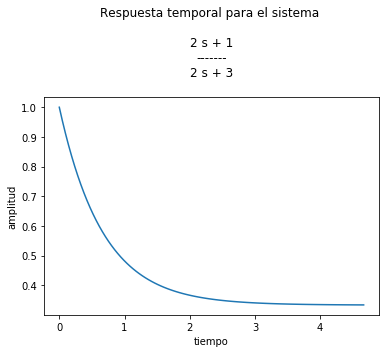

In [41]:
respuesta_error_1(2)

Para este sistema no existe un valor $K>0$ que haga el sistema inestable. 

### Ejemplo 2

Analicemos el ejemplo número 2, cuya función de transferencia es presentada acontinuación.

In [42]:
display(G2)


            0.5 s + 1
---------------------------------
0.12 s^4 + 0.58 s^3 + 0.9 s^2 + s

- ¿Cuál es la respuesta temporal para la función de transferencia del error de este sistema?

In [46]:
## Parametros del modelo

param_K = widgets.FloatSlider(value=1,min=1,max=2,step=0.01,description='Ganacia $K$')

## Definicion de la simulacion

def respuesta_error_2(K):
    E2 = 1/(1+K*G2)
    t, y = control.step_response(E2)
    plt.plot(t,y)
    plt.title('Respuesta temporal para el sistema \n%s' % (E2))
    plt.xlabel('tiempo')
    plt.ylabel('amplitud')

## Presentación de los resultados    
    
plot_respuesta_error_2 = widgets.interactive_output(respuesta_error_2,{'K':param_K})      
widgets.VBox([plot_respuesta_error_2,param_K])

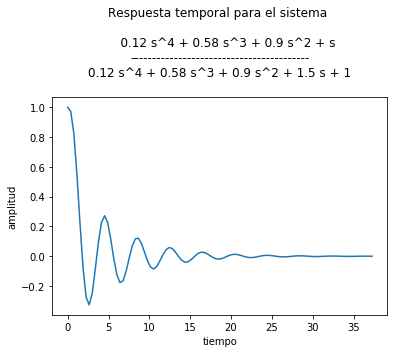

In [47]:
respuesta_error_2(1)

- ¿Qué pasa con el sistema teniendo un control diferente al control proporcional **P**?

## Control por posicionamiento de polos


     0.12 s^4 + 0.58 s^3 + 0.9 s^2 + s
-------------------------------------------
0.12 s^4 + 0.58 s^3 + 0.9 s^2 + 1.8 s + 1.6

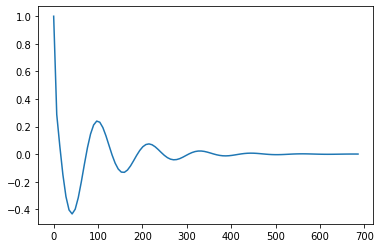

In [92]:
K = 1.6
E6 = 1/(1+K*G2); display(E6)

t,y = control.step_response(E6);
plt.plot(t,y);


          0.213 s^5 + 1.029 s^4 + 1.597 s^3 + 1.775 s^2
----------------------------------------------------------------
0.213 s^5 + 1.029 s^4 + 1.942 s^3 + 2.755 s^2 + 0.7462 s + 0.328

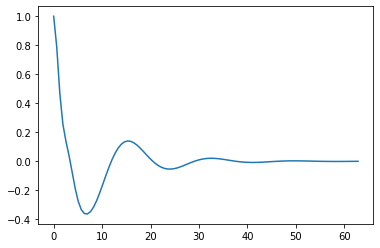

In [95]:
Ku = 1.64
Tu = 2*3.14159/1.77
Ti = Tu/2
Td = Tu/3
K = 0.2 * Ku *(1+1/(Ti*s)+Td*s)
E6 = 1/(1+K*G2); display(E6)

t,y = control.step_response(E6);
plt.plot(t,y);


    0.12 s^4 + 0.58 s^3 + 0.9 s^2 + s
-----------------------------------------
0.12 s^4 + 1.58 s^3 + 4.4 s^2 + 6.5 s + 5

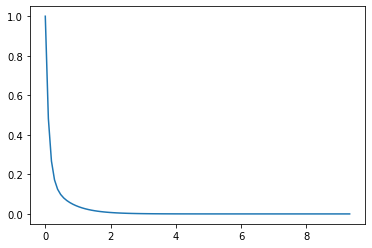

In [98]:
K = (2.5 + 1.5*s + 1*s**2)*2;
E6 = 1/(1+K*G2); display(E6)

t,y = control.step_response(E6);
plt.plot(t,y);

In [100]:
sympy.expand((ss - (-0.75+1.39194109j))*(ss-((-0.75-1.39194109j))))

s**2 + 1.5*s + 2.49999999803039

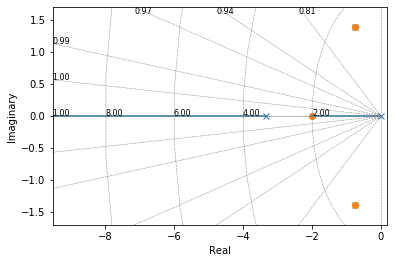

In [101]:
control.root_locus(K*G2);